In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
from coffea import hist


from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

In [4]:
web_dir = '/publicweb/m/mreid/iDM_AN_Plots/MetTriggerStudyv5'

# Define functions

In [5]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [6]:
import scipy.special
from scipy.optimize import curve_fit, fsolve
from scipy import odr

def fsigmoid(z, p0, p1):
    return 1.0 / (1.0 + np.exp(-p0*(z-p1)))
def ferf_cf(z, p0, p1, p2, p3):
    return p2 + p3*scipy.special.erf((z-p0)/p1)
def f98percentile_cf(z, p):
    return ferf_cf(z, *p) - (p[2]+p[3])*0.98
def ferf_odr(p, z):
    return p[2] + p[3]*scipy.special.erf((z-p[0])/p[1])
def f98percentile_odr(z, p):
    return ferf_odr(p, z) - (p[2]+p[3])*0.98

def make_plot(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for (l1,x),(l2,w) in zip(objs[event_selection][objs[event_selection]['fired0'] == True][variable].iteritems(),objs[event_selection][objs[event_selection]['fired0'] == True]['wgt'].iteritems()):
        #if l == variable:
        #print(l1,l2,x,w)
        h0.Fill(x,w)
    for (l1,x),(l2,w) in zip(objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)][variable].iteritems(),objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)]['wgt'].iteritems()):
        #if l == variable:
        #print(l,x)
        h1.Fill(x,w)
    #for l,x in objs[event_selection][objs[event_selection]['fired0'] == True][variable].iteritems():
    #    h0.Fill(x)
    #for l,x in objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)][variable].iteritems():
    #    h1.Fill(x)
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
    ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'], 
                label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    
    #selection_string = 'pre-selected events' if event_selection == 'df' else 'all events'
    ax.set_title(f'Trigger efficiency as a function of MET')
    ax.set_xlabel('MET pT [GeV]')
    ax.set_ylabel('Trigger efficiency')
    ax.set_ylim((0,1))
    
    return data

def make_plot_fit_cf(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    print(data['yerr'][1][minbin:maxbin])
    data['yerr'][1][minbin:maxbin][data['yerr'][1][minbin:maxbin]==0]= 0.0000001
    popt, pcov = curve_fit(ferf_cf, data['x'][minbin:maxbin], data['y'][minbin:maxbin], p0=[130,40,1,1],sigma=data['yerr'][1][minbin:maxbin],
                          bounds=([100,30,-10,-10],[250,100,10,10]))
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {pcov[i,i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_cf, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_cf(fit_range, *popt), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.legend()
    objs['cf_98'] = percentile98[0]
    objs['cf_eff'] = popt[2]+popt[3]  
    
    chi = (data['y'][minbin:maxbin] - ferf_cf(data['x'][minbin:maxbin], *popt)) / data['yerr'][1][minbin:maxbin]
    chi2 = (chi ** 2).sum()
    dof = len(data['x'][minbin:maxbin]) - len(popt)
    objs['cf_chi2'] = (chi2 / dof)
   
          
def make_plot_fit_odr(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    
    model = odr.Model(ferf_odr)
    xerror = np.repeat(data['x'][1]-data['x'][0], len(data['x'])-minbin)
    real_data = odr.RealData(data['x'][minbin:maxbin], data['y'][minbin:maxbin], sx=xerror, sy=data['yerr'][0][minbin:maxbin])
    odr_obj = odr.ODR(real_data, model, beta0=[132, 36, 0.5, 0.5])
    #odr_obj = odr.ODR(real_data, model, beta0=[130, 30, 0.5, 0.5])
    out = odr_obj.run()
    
    popt = out.beta
    perr = out.sd_beta
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {perr[i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_odr, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_odr(popt, fit_range), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.set_title(f'Trigger efficiency as a function of MET (odr fit)')
    
    ax.legend()
    objs['odr_98'] = percentile98[0]
    objs['odr_eff'] = popt[2]+popt[3]
    objs['odr_chi2'] = out.res_var

# Load data

In [7]:
Combo_samples = {
    'MC': {
        'label': 'MC',
        'color': 'C0'
        '
    },
    'Data': {
        'label': 'Data',
        'color': 'C1'
    },
        'WMuNu': {
        'label': 'WMuNu',
        'color': 'C2'
    },
}


In [8]:
full_samples = {
    'WMuNu': {
        'label': 'WMuNu',
        'color': 'C0',
        'dir': ['WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_METTrigEffiv4_WMuNu/190717_203449/0000'],
        'xsec': [7.265],
        'filename': []
    },
    'TT': {
        'label': 'TT',
        'color': 'C1',
        'dir': ['TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_TTJets/190717_212702/0000',
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_TTTo2L2Nu/190717_203118/0000',
                'TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_METTrigEffiv4_TT_diLept/190717_212751/0000'
               ],
        'xsec': [491.4,
                 687.1,
                 72.48                
                ],
        'filename': []
    },
    'WJets': {
        'label': 'WJets',
        'color': 'C2',
        'dir': [ #'WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-70To100/190717_210648/0000',
                #'WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-70To100/190719_145433/0000',
                'WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-70To100/190720_215356/0000',                
                #'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-100To200/190717_214302/0000',
                #'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-100To200/190719_145312/0000',
                'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-100To200/190720_215311/0000',
                'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-200To400/190717_210602/0000',
                'WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-400To600/190717_210737/0000',
                'WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-600To800/190717_210516/0000',   
                'WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-800To1200/190717_210423/0000',
                'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-1200To2500/190717_210227/0000',
                'WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-2500ToInf/190717_210334/0000'
            ],
        'xsec':[1288.0000,
                1393.0000,
                405.8000,
                57.7900,
                12.9100,
                5.4470,
                1.0830,
                0.0080     
                ],
        'filename': []
    },
    'DiBoson': {
        'label': 'DiBoson',
        'color': 'C3',
        'dir': ['ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_METTrigEffiv4_ZZTo2L2Nu/190717_203027/0000',
                'ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_METTrigEffiv4_ZZTo2L2Nu_ext2/190717_202941/0000',
                'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_WZTo3LNu/190717_203547/0000',
                'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_WWTo2L2Nu/190717_213431/0000',
                'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_METTrigEffiv4_WWJJToLNuLNu/190717_213530/0000'
                ],
        'xsec':[0.6008,
                0.6008, #double check later
                4.6580,
                11.08,
                2.1630
                ],
        'filename': []
    },
    'Data': {
        'label': 'Data',
        'color': 'C4',
        'dir': ['SingleMuon/crab_METTrigEffiv4_singleMu_RunA_Jun/190717_214003/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunA_Sep/190717_213909/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunA_May/190717_214051/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunB_Sep/190717_214323/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunC_Sep/190717_214234/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Apr/190717_214417/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000',
                'SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0001'
                ],
        'xsec':[1,1,1,1,1,1,1,1],
        'filename': []
    },
    'Prompt': {
        'label': 'Prompt',
        'color': 'C5',
        'dir': [
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunA1/190720_235649/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunA2/190720_235605/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunA3/190720_235518/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunB1/190720_235427/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunC1/190720_235032/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunC2/190720_235204/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunC3/190720_235118/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000',
                'SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0001'

                ],
        'xsec':[1,1,1,1,1,1,1,1,1],
        'filename': []
    },
}


In [ ]:
data_samples = {
     'DataA': {
        'label': 'DataA',
        'color': 'C0',
        'dir': [
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunA_Jun/190716_230744/0000',
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunA_Sep/190716_230650/0000',
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunA_May/190716_230846/0000'
               ],
        'filename': []
    },
    'DataB': {
        'label': 'DataB',
        'color': 'C1',
        'dir': [
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunB_Sep/190716_231126/0000'
               ],
        'filename': []
    },
    'DataC': {
        'label': 'DataC',
        'color': 'C2',
        'dir': [
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunC_Sep/190716_231037/0000',
               ],
        'filename': []
    },
    'DataD': {
        'label': 'DataD',
        'color': 'C4',
        'dir': [
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunA_Jun/190715_160119/0000',
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunA_Sep/190715_160026/0000',
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunA_May/190715_181401/0000',
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunB_Sep/190715_181315/0000',
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunC_Sep/190715_160409/0000',
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunC_Sep/190715_160409/0001',
                #'SingleMuon/crab_MetTrigEffiv2_singleMu_RunC_Sep/190715_160409/0002',
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunD_Apr/190716_231224/0000',
                'SingleMuon/crab_METTrigEffiv3_singleMu_RunD_Jan/190716_230945/0000'
               ],
        'filename': []
    }
}

In [ ]:
W_samples = {
    'WJets': {
        'label': 'WJets',
        'color': 'C2',
        'dir': ['WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-70To100/190717_210648/0000',
                'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-100To200/190717_214302/0000',
                'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-200To400/190717_210602/0000',
                'WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-400To600/190717_210737/0000',
                'WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-600To800/190717_210516/0000',   
                'WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-800To1200/190717_210423/0000',
                'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-1200To2500/190717_210227/0000',
                'WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-2500ToInf/190717_210334/0000'
            ],
        'xsec':[1288.0000,
                1393.0000,
                405.8000,
                57.7900,
                12.9100,
                5.4470,
                1.0830,
                0.0080     
                ],
        'filename': []
    },
    'WMuNu': {
        'label': 'WMuNu',
        'color': 'C0',
        'dir': [
                'WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_METTrigEffiv4_WMuNu/190717_203449/0000'
                ],
        'xsec':[7.265],
        'filename': []
    }
}

In [ ]:
TT_samples = {
    'TTJets': {
        'label': 'TTJets',
        'color': 'C0',
        'dir': ['TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_TTJets/190717_212702/0000'
               ],
        'xsec': [491.4               
                ],
        'filename': []
    },
        'TT': {
        'label': 'TT',
        'color': 'C1',
        'dir': [
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_TTTo2L2Nu/190717_203118/0000'
               ],
        'xsec': [
                 687.1               
                ],
        'filename': []
    },
        'TTDi': {
        'label': 'dilept',
        'color': 'C2',
        'dir': [
                'TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_METTrigEffiv4_TT_diLept/190717_212751/0000'
               ],
        'xsec': [
                 72.48                
                ],
        'filename': []
    }
    
}


In [ ]:
Di_samples = {
    'ZZ': {
        'label': 'ZZ',
        'color': 'C0',
        'dir': ['ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_METTrigEffiv4_ZZTo2L2Nu/190717_203027/0000',
                'ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_METTrigEffiv4_ZZTo2L2Nu_ext2/190717_202941/0000'
                ],
        'xsec':[0.6008,
                0.6008
                ],
        'filename': []
    },
        'WZ': {
        'label': 'WZ',
        'color': 'C1',
        'dir': [
                'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_WZTo3LNu/190717_203547/0000'
                ],
        'xsec':[
                4.6580
                ],
        'filename': []
    },
        'WW': {
        'label': 'WW',
        'color': 'C2',
        'dir': [
                'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_WWTo2L2Nu/190717_213431/0000'
                ],
        'xsec':[
                11.08
                ],
        'filename': []
    },
        'WWJJ': {
        'label': 'WWJJ',
        'color': 'C3',
        'dir': [
                'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_METTrigEffiv4_WWJJToLNuLNu/190717_213530/0000'
                ],
        'xsec':[
                2.1630
                ],
        'filename': []
    }
}



In [9]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")
redirector = 'root://cmseos.fnal.gov'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8'
#sample_list = [Di_samples,W_samples,TT_samples]
sample_list = [full_samples]
#sample_list = [Combo_samples]
for samples in sample_list:
    for sample, objs in samples.items():
        for sample_index,(xsec, dirs) in enumerate(zip(objs['xsec'],objs['dir'])):
            print(dirs,xsec,sample_index)
    #dirs = objs['dir']
            status, listing = xrdfs.dirlist(f'{basedir}/{dirs}', DirListFlags.STAT)
        #print(listing)
            for file in listing:
                if '.root' in file.name:
                    samples[sample]['filename'].append((f'{redirector}/{basedir}/{dirs}/{file.name}',xsec,sample_index))


WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_METTrigEffiv4_WMuNu/190717_203449/0000 7.265 0
TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_TTJets/190717_212702/0000 491.4 0
TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv4_TTTo2L2Nu/190717_203118/0000 687.1 1
TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_METTrigEffiv4_TT_diLept/190717_212751/0000 72.48 2
WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-70To100/190720_215356/0000 1288.0 0
WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-100To200/190720_215311/0000 1393.0 1
WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-200To400/190717_210602/0000 405.8 2
WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-400To600/190717_210737/0000 57.79 3
WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv4_WJetsToLNu_HT-600To800/190717_210516/0000 12.9

In [10]:
%%time
MAX_FILES=None
#global_file_counter = 1
#sample_list = [Di_samples,W_samples,TT_samples]
sample_list = [full_samples]
#sample_list = [Combo_samples]

for samples in sample_list:
    for sample, objs in samples.items():
        #objs['df'] = []
        objs['enrich'] = []
        print(objs['label'])
        sample_counter=0
        #sum_gen_wgts=[]
        sum_gen_wgt=0
        file_counter = 1
        max_samples=0
        for filex,xsec,sample_index in objs['filename'][slice(0,MAX_FILES)]:
            if file_counter % 10 == 1:
                total = len(objs['filename'][slice(0,MAX_FILES)])
                print(f'Reading file {file_counter} of {total}')
                  #f' global {global_file_counter} of {num_files_total}'
                  #f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
            file_counter +=1
        #global_file_counter +=1
        
            file = uproot.open(filex)
            objs['trig_tree'] = file['RECO_dsa/MetTrigSelfEffiForMuTrack']
            try:
                #objs['df'].append(objs['trig_tree'].pandas.df())
                objs['df'] = objs['trig_tree'].pandas.df()
                objs['df']['wgt'] = objs['df']['genwgt']*xsec
                objs['df']['sumwgt_counter'] = sample_index
                #objs['df']['sumwgt'] = 0
                objs['enrich'].append(objs['df'][(objs['df']['pt'].groupby('entry').nth(0) > 25) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 150) & (objs['df']['recoJetPt2'] < 100)&(abs(objs['df']['recoJetEta'])<2.4) & (objs['df']['fired0']==1)].groupby('entry').nth(0))
                #objs['enrich'].append(objs['df'][(objs['df']['recoJetPt'] > 150) & (objs['df']['recoJetPt2'] < 100)&(abs(objs['df']['recoJetEta'])<2.4) & (objs['df']['fired0']==1)].groupby('entry').nth(0))

            except:
                print("skipped: ",filex)
                continue
            max_samples=sample_index

        objs['enrich'] = pd.concat(objs['enrich']).reset_index()
        objs['enrich']=objs['enrich'].join(objs['enrich'].groupby('sumwgt_counter')['genwgt'].sum(),on='sumwgt_counter',rsuffix='_sum')
        objs['enrich']['wgt'] = objs['enrich']['wgt']/objs['enrich']['genwgt_sum']
    

WMuNu
Reading file 1 of 2
TT
Reading file 1 of 48
Reading file 11 of 48
Reading file 21 of 48
Reading file 31 of 48
Reading file 41 of 48
WJets
Reading file 1 of 118
Reading file 11 of 118
Reading file 21 of 118
Reading file 31 of 118
Reading file 41 of 118
Reading file 51 of 118
Reading file 61 of 118
Reading file 71 of 118
Reading file 81 of 118
Reading file 91 of 118
Reading file 101 of 118
Reading file 111 of 118
DiBoson
Reading file 1 of 42
Reading file 11 of 42
Reading file 21 of 42
Reading file 31 of 42
Reading file 41 of 42
Data
Reading file 1 of 3061
Reading file 11 of 3061
Reading file 21 of 3061
Reading file 31 of 3061
Reading file 41 of 3061
Reading file 51 of 3061
Reading file 61 of 3061
Reading file 71 of 3061
Reading file 81 of 3061
Reading file 91 of 3061
Reading file 101 of 3061
Reading file 111 of 3061
Reading file 121 of 3061
Reading file 131 of 3061
Reading file 141 of 3061
Reading file 151 of 3061
Reading file 161 of 3061
Reading file 171 of 3061
Reading file 181 o

skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_4.root
Reading file 1981 of 3061
Reading file 1991 of 3061
Reading file 2001 of 3061
Reading file 2011 of 3061
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_431.root
Reading file 2021 of 3061
Reading file 2031 of 3061
Reading file 2041 of 3061
Reading file 2051 of 3061
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_472.root
Reading file 2061 of 3061
Reading file 2071 of 3061
Reading file 2081 of 3061
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_5.root
Reading file 2

Reading file 2561 of 3061
Reading file 2571 of 3061
Reading file 2581 of 3061
Reading file 2591 of 3061
Reading file 2601 of 3061
Reading file 2611 of 3061
Reading file 2621 of 3061
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_979.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_980.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_singleMu_RunD_Jan/190717_214139/0000/output_981.root
Reading file 2631 of 3061
Reading file 2641 of 3061
Reading file 2651 of 3061
Reading file 2661 of 3061
Reading file 2671 of 3061
Reading file 2681 of 3061
Reading file 2691 of 3061
Reading file 2701 of 3061
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetT

Reading file 941 of 3331
Reading file 951 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunC3/190720_235118/0000/output_117.root
Reading file 961 of 3331
Reading file 971 of 3331
Reading file 981 of 3331
Reading file 991 of 3331
Reading file 1001 of 3331
Reading file 1011 of 3331
Reading file 1021 of 3331
Reading file 1031 of 3331
Reading file 1041 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000/output_1.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000/output_10.root
Reading file 1051 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000/output_11.root
Reading file 1

Reading file 2241 of 3331
Reading file 2251 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000/output_4.root
Reading file 2261 of 3331
Reading file 2271 of 3331
Reading file 2281 of 3331
Reading file 2291 of 3331
Reading file 2301 of 3331
Reading file 2311 of 3331
Reading file 2321 of 3331
Reading file 2331 of 3331
Reading file 2341 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000/output_474.root
Reading file 2351 of 3331
Reading file 2361 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0000/output_5.root
Reading file 2371 of 3331
Reading file 2381 of 3331
Reading file 2391 of 3331
Reading file 2401 of 3331
Reading file 2411 of 3331
Reading file 2421 of 33

skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0001/output_1112.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0001/output_1113.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0001/output_1114.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0001/output_1115.root
Reading file 3041 of 3331
Reading file 3051 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv8/SingleMuon/crab_METTrigEffiv4_Prompt_RunD2/190720_235339/0001/output_1136.root
Reading file 3061 of 3331
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntup

In [12]:
#full_samples['Data']['enrich']=full_samples['Data']['enrich'].reset_index()
#print(full_samples['Data']['enrich'])#[full_samples['Data']['enrich']['fired']==1])
Combo_samples['Data']['enrich'] =  pd.concat([full_samples['Data']['enrich'],full_samples['Prompt']['enrich']])
Combo_samples['MC']['enrich'] = pd.concat([full_samples['WMuNu']['enrich'],full_samples['WJets']['enrich'],full_samples['DiBoson']['enrich'],full_samples['TT']['enrich']])
Combo_samples['WMuNu']['enrich'] = full_samples['WMuNu']['enrich']

# Comparison of triggered vs pre-selected distributions with Coffea

# Comparison of triggered vs pre-selected distributions without Coffea

In [13]:
eff_plots = OrderedDict({
    'pt': {
        'axis': np.array(np.arange(25,80,3), dtype='float64'),
        'range': [25, 100],
        'label': 'Leading muon pT [GeV]'
    },
    'eta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading muon eta'
    },
    'phi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading muon phi'
    },
    'recoJetPt': {
        'axis': np.array(np.arange(50,500,50), dtype='float64'),
        'range': [100, 1000],
        'label': 'Leading jet pT [GeV]'
    },
    'recoJetEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading jet eta'
    },
    'recoJetPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading jet phi'
    },
    'recoPFMetPt': {
        'axis': np.array(np.arange(40,300,10), dtype='float64'),
        'range': [0, 450],
        'label': 'MET pT [GeV]'
    },
    'recoPFMetPhi': {
         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
         'range':[-3.2,3.2],
         'label': 'MET phi'
     },
})
#     'recoPFMetPhi': {
#         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
#         'label': 'MET phi'
#     },

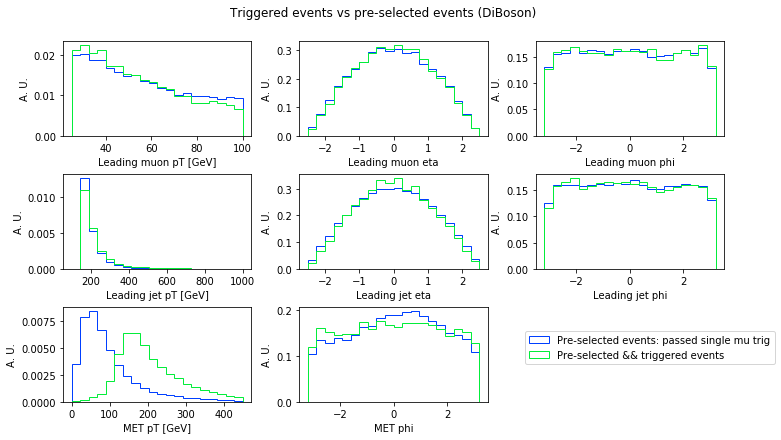

In [19]:
sample = 'DiBoson'
#sample = 'WMuNu'
#sample = 'TT'
#sample = 'WJets'
#sample = 'Data'
#sample = 'Prompt'
samples = full_samples

fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle(f'Triggered events vs pre-selected events ({samples[sample]["label"]})')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
#axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, props) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = props['axis']
    kwargs = {'range': props['range'], 'bins':20, 'density': True, 'histtype':'step', 'log':False}
    
    df = samples[sample]['enrich']
    #print(df)
    #x.hist(df.query('fired0==True')[column].groupby('entry').nth(0), **kwargs, 
    #       label='Pre-selected events: passed single mu trig');
    #x.hist(df.query('fired0==True & fired==True')[column].groupby('entry').nth(0), **kwargs, 
    #       label='Pre-selected && triggered events');
    #print(df[['fired0','fired','recoPFMetPt']].groupby('entry').nth(0))
    #print(len(df[df['fired0']==True].groupby('entry').nth(0)))
    #print(len(df[['fired0','fired','recoPFMetPt']].groupby('entry').nth(0)))
    ax.hist(df[(df['fired0']==1)][column], **kwargs, weights=df[(df['fired0']==1)]['wgt'],
            label='Pre-selected events: passed single mu trig');
    ax.hist(df[(df['fired0']==1) & (df['fired']==1)][column], **kwargs, weights=df[(df['fired0']==1) & (df['fired']==1)]['wgt'],
            label='Pre-selected && triggered events');
    ax.set_xlabel(props['label'])
    ax.set_ylabel('A. U.')

ax.legend(loc=(1.2 ,0.4))
fig.savefig(f'{web_dir}/Trig_vs_preselected_{sample}.png', bbox_inches='tight')

# Trigger efficiency of `MET_120` vs kinematic variables -- pre-selected events

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficien

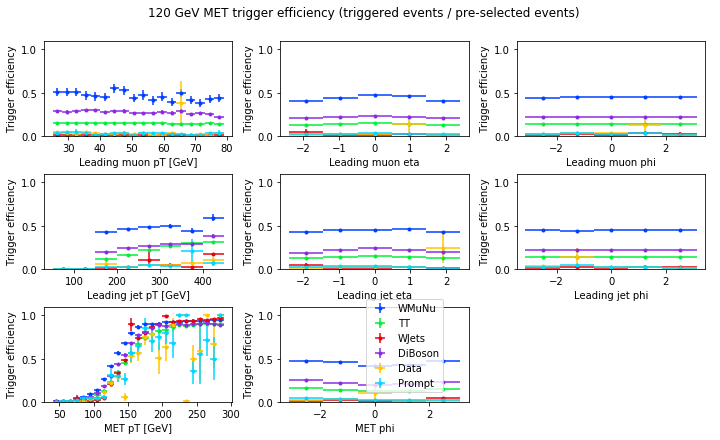

In [20]:
fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('120 GeV MET trigger efficiency (triggered events / pre-selected events)')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
#axes[2,1].axis('off')
axes[2,2].axis('off')
samples = full_samples
for index, (column, properties) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = properties['axis']
    
    for sample, objs in samples.items():
        #if objs['label'] is not 'WJets':
        #    continue
        df = samples[sample]['enrich']#.groupby('entry').nth(0)
        if 'h0' in locals():
            del h0,h1
    
        h0 = ROOT.TH1F(f'h0_1', '', len(bin_edges)-1, bin_edges)
        h1 = ROOT.TH1F(f'h1_1', '', len(bin_edges)-1, bin_edges)

        #or l,x in objs['df'].query('fired0==True')[column].groupby('entry').nth(0).iteritems():
        #   h0.Fill(x)
        #or l,x in objs['df'].query('fired0==True & fired==True')[column].groupby('entry').nth(0).iteritems():
        #   h1.Fill(x)
            
        for (l1,x),(l2,w) in zip(df[df['fired0']==True][column].iteritems(),df[df['fired0']==True]['wgt'].iteritems()):
            h0.Fill(x,w)
        for (l1,x),(l2,w) in zip(df[(df['fired0']==True) & (df['fired']==True)][column].iteritems(),df[(df['fired0']==True) & (df['fired']==True)]['wgt'].iteritems()):
            h1.Fill(x,w)

        eff = ROOT.TEfficiency(h1, h0)
        data = extract_teffi(eff)

        #print(data['x'])
        if 'Pt' in column:# 'pt':
            xerr=np.diff(bin_edges)/2
        else:
            xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
        if len(data['x']) != len(properties['axis'])-1:
            recover = np.add(np.diff(properties['axis'])/2,properties['axis'][:-1])
            data['x']= np.append(data['x'],recover[len(data['x']):])
            data['y']= np.append(data['y'],np.full(len(recover)-len(data['y']),0))
            data['yerr']= np.append(data['yerr'],np.full((2,len(recover)-len(data['yerr'][0])),0),axis=1)
        #print(xerr)
        #print(data['x'])
        ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'],
                    fmt='o', label=f'{objs["label"]}', ms=3, c=objs['color'])
        ax.set_xlabel(properties['label'])
        ax.set_ylabel('Trigger efficiency')
        ax.set_ylim(0,1.1)
        
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(-0.8,0.1));

fig.savefig(f'{web_dir}/trigger_eff_preselected.png', bbox_inches='tight')

[0.00011347 0.00019133 0.00039654 0.02600227 0.00163426 0.00375304
 0.00791613 0.01553757 0.0033251  0.0041638  0.00488678 0.0801013
 0.00559717 0.0056699  0.00542229 0.00593215 0.03853343 0.00573789
 0.00579483 0.00612655 0.00677751 0.00652017 0.00649718 0.00752559]
[MC]
fit parameter 1-sigma error
———————————–
144.44 +- 0.33
40.52 +- 0.91
0.44 +- 0.00
0.44 +- 0.00

[0.00080991 0.0018897  0.00195634 0.00499637 0.00743409 0.01324892
 0.01231981 0.0176381  0.04306508 0.04553642 0.06598431 0.06959609
 0.06952783 0.10258482 0.08067356 0.12319693 0.10806691 0.09844976
 0.         0.01522514 0.1112913  0.24604835 0.15614713 0.193079  ]


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


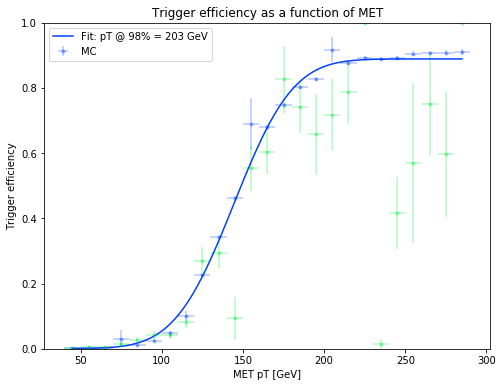

In [23]:
# Using cf (curve_fit), no x or y errors in the fit
#samples = full_samples
samples = Combo_samples
fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    #if props['label'] is not 'DiBoson':
    #    continue
    make_plot_fit_cf(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='enrich')

#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_TT.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_diboson.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_data.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_full.png', bbox_inches='tight')
fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_combo.png', bbox_inches='tight')

[MC]
fit parameter 1-sigma error
———————————–
149.17 +- 2.16
43.34 +- 2.02
0.45 +- 0.00
0.45 +- 0.00

[Data]
fit parameter 1-sigma error
———————————–
132.00 +- 0.00
36.00 +- 0.00
0.50 +- 0.00
0.50 +- 0.00



KeyError: 'enrich'

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


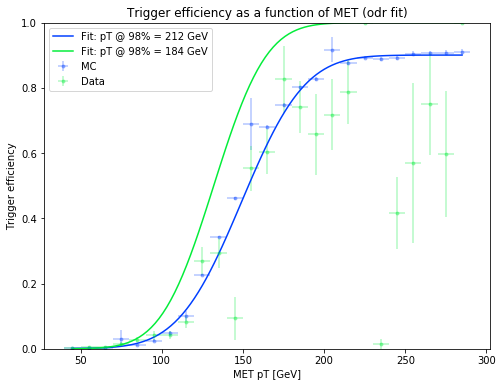

In [24]:
# Using ODR, includes both x errors (bin width) and y errors
#samples = full_samples
samples = Combo_samples
fig, ax = plt.subplots(figsize=(8,6))
for index, (sample, props) in enumerate(samples.items()):
    #if props['label'] is 'Data':
    #    continue
    make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='enrich')

#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_TT.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_diboson.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_data.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_full.png', bbox_inches='tight')
fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_combo.png', bbox_inches='tight')

# Trigger efficiency of `MET_120`  vs kinematic distributions -- all events

In [25]:
#samples= full_samples
#info = pd.Dataframe()
df = {'labels' : [], 'samples' :[],'trig': [],'cf_98':[],'odr_98':[],'cf_eff':[],'odr_eff':[],'cf_chi2':[],'odr_chi2':[],'entries':[]}
for index, (sample, props) in enumerate(full_samples.items()):
    df['labels'].append(props['label'])
    df['samples'].append(props['enrich']['genwgt'].sum())
    df['trig'].append(props['enrich'][props['enrich']['fired']==1]['genwgt'].sum())
    df['entries'].append(len(props['enrich'].index))
    df['cf_98'].append(props['cf_98'])
    df['odr_98'].append(props['odr_98'])
    df['cf_eff'].append(props['cf_eff'])
    df['odr_eff'].append(props['odr_eff'])
    df['cf_chi2'].append(props['cf_chi2'])
    df['odr_chi2'].append(props['odr_chi2'])
    print(props['label'],":",props['enrich']['genwgt'].sum())
for index, (sample, props) in enumerate(Combo_samples.items()):
    if props['label'] == 'MC':
        df['labels'].append(props['label'])
        df['samples'].append(props['enrich']['genwgt'].sum())
        df['trig'].append(props['enrich'][props['enrich']['fired']==1]['genwgt'].sum())
        df['entries'].append(len(props['enrich'].index))
        df['cf_98'].append(props['cf_98'])
        df['odr_98'].append(props['odr_98'])
        df['cf_eff'].append(props['cf_eff'])
        df['odr_eff'].append(props['odr_eff'])
        df['cf_chi2'].append(props['cf_chi2'])
        df['odr_chi2'].append(props['odr_chi2'])
        print(props['label'],":",props['enrich']['genwgt'].sum())
info = pd.DataFrame(df)
print(info)

WMuNu : 16507.0
TT : 53452040.0
WJets : 3674282.5
DiBoson : 529057.94
Data : 12332.0
Prompt : 13196.0
MC : 57671870.0
    labels       samples          trig       cf_98      odr_98    cf_eff  \
0    WMuNu  1.650700e+04  7.381000e+03  180.248102  186.382856  0.928545   
1       TT  5.345204e+07  8.283663e+06  204.243753  218.045709  0.880014   
2    WJets  3.674282e+06  7.978741e+05  195.351788  199.253228  0.938635   
3  DiBoson  5.290579e+05  1.223050e+05  192.040140  197.746141  0.896345   
4     Data  1.233200e+04  3.420000e+02  169.330958  184.279912  1.000001   
5   Prompt  1.319600e+04  3.950000e+02  169.197241  184.279912  1.000001   
6       MC  5.767187e+07  9.211224e+06  203.270760  212.104572  0.888659   

    odr_eff     cf_chi2  odr_chi2  entries  
0  0.931266    0.675116  0.165641    16507  
1  0.896550    5.227726  0.337502   819930  
2  0.949818   11.449965  2.396014  3683854  
3  0.900498    0.788906  0.246040   190963  
4  1.000000  303.153354  0.000000    12332  
5  